In [16]:
import numpy as np
import pandas as pd
import PIL.Image as Image
import matplotlib.pyplot as plt

# Process data

In [17]:
IMAGE_SIZE = (28, 28)
EPOCH = 1000
LEARNING_RATE = 0.00001

# Import data
data = pd.read_csv(r"../digit-recognizer/train.csv")
data_test = pd.read_csv(r"../digit-recognizer/test.csv")    

# Get labels and image array from data
labels : np.ndarray = data.values[:, 0]
images : np.ndarray = data.values[:, 1:].astype('uint8')

images_test : np.ndarray = data_test.values.astype('uint8')

# Reference for backpropagation (from 3b1b neural network video)

![title](image.png)

In [25]:
class Model:
    def __init__(self, input, hidden, output, lr):
        # Initialize weight and bias
        self.w_input = np.random.normal(size=(input, hidden))
        self.b_input = np.zeros(hidden)
        self.w_hidden = np.random.normal(size=(hidden, output))
        self.b_hidden = np.zeros(output)
        
        self.lr = lr
        self.costs = []

    def _sigmoid(self, x, derive=False):
        if derive:
            return self._sigmoid(x) * (1-self._sigmoid(x))
        return 1 / (1 + np.exp(-x))

    def _softmax(self, x : np.ndarray):
        new_x : np.ndarray = np.zeros(len(x))
        x = np.subtract(x, np.max(x))
        # print(np.max(x))
        
        for i in range(len(x)):
            new_x[i] = np.exp(x[i]) / np.sum(np.exp(x), axis=0)
            # print(np.exp(x[i]))
        # print(new_x)
        return new_x 

    def plot(self):
        plt.plot(self.costs, 'bo')
        plt.xlabel("Data")
        plt.ylabel("Costs")
        plt.show()



class Softmax(Model):
    def __init__(self, input, hidden, output, lr):
        super().__init__(input, hidden, output, lr)
    
    def forward(self, x):
        x = np.dot(x, self.w_input)
        # x += self.b_input
        # x = self._sigmoid(x)
        x = np.dot(x, self.w_hidden)
        x = np.clip(x, 1e-7, 1e4)
        # x += self.b_hidden
        x = self._softmax(x)
        
        return x

    def train(self, input: np.ndarray, pred: np.ndarray, label: np.ndarray, debug=False):
        # ============================================
        # Softmax with Cross Entropy Loss
        
        # cost = -sum(label * ln(pred)) = -ln(pred)
        # label array only has one 1 value (the correct label), so technically, -ln(pred) is also correct
        # pred = _softmax(out)
        # out = w * input
        # d_cost = -1 / (pred)
        # d_pred = pred * (1 - pred) # From StatQuest
        # d_cost * d_pred = pred[i] - 1
        # self.w_input[j, i] -= step

        d_cost = -1 / pred[np.argmax(label)] # d_cost
        d_pred = np.zeros(len(pred))
        out = np.dot(input, self.w_input)
        # d_hidden = self.w_hidden

        for i, p in enumerate(pred): # d_pred (derivative of _softmax)
            # d__softmax/d_y1 = (e**y1 * (e**y2 + e**y3 + ...)) / (e**y1 + e**y2 + e**y3 + ...)**2
            d_pred[i] = np.exp(p) * np.sum(np.exp(pred[pred != p])) / np.sum(np.exp(pred))**2
                    
        # print(input.shape, self.w_hidden.shape, d_pred.shape, d_cost)
        # print(np.dot(self.w_hidden, d_pred).shape)
        
        self.w_input += (np.outer(input, np.dot(self.w_hidden, d_pred) * d_cost) * self.lr)
        # self.b_hidden += d_pred * d_cost * self.lr
        self.w_hidden += (np.outer(out, d_pred) * d_cost * self.lr)
        # self.b_input += d_hidden * d_pred * d_cost * self.lr

        self.costs.append(-np.log(pred[np.argmax(label)]))
        
        # Debug
        if (debug):
            print("Cost: ", -np.log(pred[np.argmax(label)]))
            # print("Step: ", step)
            # print("d_pred: ", d_pred)
            # print("d_cost: ", d_cost)
            
        # ============================================



class Sigmoid(Model):
    def __init__(self, input, hidden, output, lr):
        super().__init__(input, hidden, output, lr)

    def forward(self, x):
        x = np.dot(x, self.w_input)
        # x += self.b_input
        x = np.dot(x, self.w_hidden)
        # x += self.b_hidden
        x = self._sigmoid(x)
        
        return x

    def train(self, input: np.ndarray, pred: np.ndarray, label: np.ndarray, debug=False):
        # ============================================
        # # Sigmoid with MSELoss (Mean Squared Error)
        # cost = 1/len(pred) * np.sum(pred-label)**2
        # d_cost/d_pred = 2/len(pred) * (pred-label)
        # d_cost = 10 (1 for each prediction?)
        
        # pred = _sigmoid(out) {a(L)}
        # d_pred/d_out = self._sigmoid(out, derive=True)
        # d_pred = 10 (1 for each output?)     
        
        # out = dot(dot(input, w_input), w_hidden)
        # d_out/d_hidden = w_hidden (how much does hidden layer affects output, which depends on hidden layer's weight)
        # d_out = hidden_size * output_size {(16, 10) matrix}

        # hidden = dot(input, w_input)
        # d_hidden/d_w_input = input (how much does weight affects hidden values, which depends on input)

        # Gradient Descent
        d_cost = 2/len(pred) * (pred-label) # (10, )
        d_pred = self._sigmoid(np.dot(np.dot(input, self.w_input), self.w_hidden), derive=True) # (10, )
        d_out = self.w_hidden # (16, 10)
        d_hidden = input # (784, )

        step = np.outer(d_hidden, np.dot(d_out, d_pred * d_cost))
        # print(np.dot(input, self.w_input).shape)
        self.w_hidden -= np.outer(np.dot(input, self.w_input), d_pred * d_cost)
        self.w_input -= step
        
        self.costs.append(np.sum(pred-label)**2/len(pred))

        # Debug
        if (debug):
            print("Cost: ", np.sum(pred-label)**2/len(pred))
            # print("Step: ", step)
            # print("d_pred: ", d_pred)
            # print("d_cost: ", d_cost)
            
        # ============================================

# <center> MODELS </center>

# Test

Cost:  0.09999980000010003
Data 2000: Wrong = 1755, Accuracy: 12.206103051525758%
Cost:  0.09999980000010003
Data 4000: Wrong = 3386, Accuracy: 15.328832208052006%
Cost:  0.09999980000010003
Data 6000: Wrong = 5081, Accuracy: 15.302550425070848%
Cost:  0.09999980000010003
Data 8000: Wrong = 6716, Accuracy: 16.03950493811726%
Cost:  0.09999980000010002
Data 10000: Wrong = 8335, Accuracy: 16.641664166416632%
Cost:  0.09999980000010003
Data 12000: Wrong = 9925, Accuracy: 17.28477373114427%
Cost:  0.09999980000010002
Data 14000: Wrong = 11547, Accuracy: 17.51553682405887%
Cost:  0.09999980000010003
Data 16000: Wrong = 13171, Accuracy: 17.67610475654729%
Cost:  2.3029673352947735e-13
Data 18000: Wrong = 14778, Accuracy: 17.89543863547975%


C:\Users\MAS GAMING\AppData\Local\Temp\ipykernel_19244\3590800197.py:15: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Cost:  0.09999980000010003
Data 20000: Wrong = 16354, Accuracy: 18.225911295564785%
Cost:  8.099999999999998e-14
Data 22000: Wrong = 17967, Accuracy: 18.328105822991958%
Cost:  8.099999999999998e-14
Data 24000: Wrong = 19561, Accuracy: 18.492437184882704%
Cost:  0.09999980000010003
Data 26000: Wrong = 21176, Accuracy: 18.550713488980335%
Cost:  0.09999980000010003
Data 28000: Wrong = 22796, Accuracy: 18.582806528804596%
Cost:  8.099999999999998e-14
Data 30000: Wrong = 24381, Accuracy: 18.72729090969699%
Cost:  0.09999980000010003
Data 32000: Wrong = 26013, Accuracy: 18.70683458858089%
Cost:  0.09999980000010002
Data 34000: Wrong = 27621, Accuracy: 18.75937527574341%
Cost:  0.09999980000010003
Data 36000: Wrong = 29217, Accuracy: 18.839412205894618%
Cost:  8.099999999999998e-14
Data 38000: Wrong = 30809, Accuracy: 18.92155056712018%
Cost:  0.09999980000010003
Data 40000: Wrong = 32375, Accuracy: 19.060476511912796%
Cost:  0.09999980000010002
Data 42000: Wrong = 33961, Accuracy: 19.13855

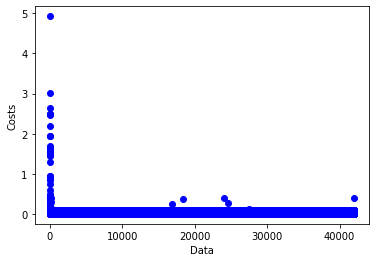

Epoch: 1 --> Wrong: 33961, Accuracy: 19.140476190476193%

Cost:  0.09999980000010003
Data 2000: Wrong = 1619, Accuracy: 19.009504752376188%
Cost:  0.09999980000010003
Data 4000: Wrong = 3200, Accuracy: 19.97999499874969%
Cost:  8.099999999999998e-14
Data 6000: Wrong = 4821, Accuracy: 19.636606101016838%
Cost:  0.09999980000010003
Data 8000: Wrong = 6406, Accuracy: 19.914989373671716%
Cost:  0.09999980000010002
Data 10000: Wrong = 8032, Accuracy: 19.671967196719677%
Cost:  0.09999980000010003
Data 12000: Wrong = 9623, Accuracy: 19.80165013751146%
Cost:  0.09999980000010002
Data 14000: Wrong = 11220, Accuracy: 19.8514179584256%
Cost:  0.09999980000010003
Data 16000: Wrong = 12845, Accuracy: 19.713732108256764%
Cost:  8.099999999999998e-14
Data 18000: Wrong = 14456, Accuracy: 19.684426912606256%
Cost:  0.09999980000010003
Data 20000: Wrong = 16026, Accuracy: 19.86599329966498%
Cost:  0.09999980000010003
Data 22000: Wrong = 17645, Accuracy: 19.791808718578125%
Cost:  8.099999999999998e-14


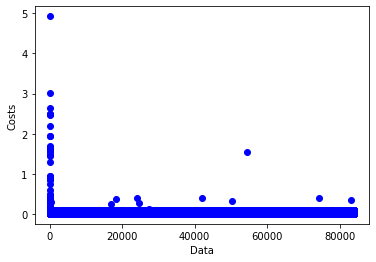

Epoch: 2 --> Wrong: 33635, Accuracy: 19.91666666666667%

Cost:  0.09999980000010003
Data 2000: Wrong = 1605, Accuracy: 19.709854927463738%
Cost:  0.09999980000010003
Data 4000: Wrong = 3177, Accuracy: 20.55513878469617%
Cost:  8.099999999999998e-14
Data 6000: Wrong = 4797, Accuracy: 20.036672778796472%
Cost:  0.09999980000010003
Data 8000: Wrong = 6375, Accuracy: 20.302537817227147%
Cost:  0.09999980000010002
Data 10000: Wrong = 7984, Accuracy: 20.152015201520157%
Cost:  0.09999980000010003
Data 12000: Wrong = 9587, Accuracy: 20.10167513959496%
Cost:  0.09999980000010002
Data 14000: Wrong = 11196, Accuracy: 20.02285877562683%
Cost:  0.09999980000010003
Data 16000: Wrong = 12803, Accuracy: 19.97624851553222%
Cost:  8.099999999999998e-14
Data 18000: Wrong = 14433, Accuracy: 19.812211789543866%
Cost:  0.09999980000010003
Data 20000: Wrong = 16017, Accuracy: 19.910995549777482%
Cost:  0.09996882972975477
Data 22000: Wrong = 17623, Accuracy: 19.89181326423929%
Cost:  8.099999999999998e-14
D

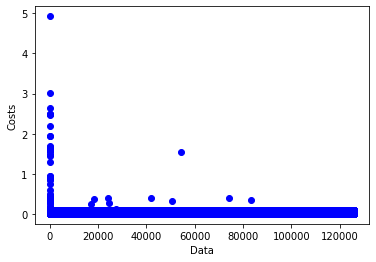

Epoch: 3 --> Wrong: 33602, Accuracy: 19.995238095238093%

Cost:  0.09999980000010003
Data 2000: Wrong = 1606, Accuracy: 19.659829914957484%
Cost:  0.09999980000010003
Data 4000: Wrong = 3200, Accuracy: 19.97999499874969%
Cost:  8.099999999999998e-14
Data 6000: Wrong = 4812, Accuracy: 19.7866311051842%
Cost:  0.09999980000010003
Data 8000: Wrong = 6392, Accuracy: 20.090011251406423%
Cost:  0.09999980000010002
Data 10000: Wrong = 7999, Accuracy: 20.002000200019992%
Cost:  0.09999980000010003
Data 12000: Wrong = 9586, Accuracy: 20.11000916743062%
Cost:  0.09999980000010002
Data 14000: Wrong = 11184, Accuracy: 20.10857918422745%
Cost:  0.09999980000010003
Data 16000: Wrong = 12795, Accuracy: 20.026251640727537%
Cost:  8.099999999999998e-14
Data 18000: Wrong = 14412, Accuracy: 19.92888493805212%
Cost:  0.09999980000010003
Data 20000: Wrong = 15983, Accuracy: 20.08100405020251%


KeyboardInterrupt: 

In [26]:
# model = Softmax(IMAGE_SIZE[0]*IMAGE_SIZE[1], 16, 10, LEARNING_RATE)
model = Sigmoid(IMAGE_SIZE[0]*IMAGE_SIZE[1], 16, 10, LEARNING_RATE)

# print(np.array([[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4]]) * np.array([2, 2, 3, 3]))

for i in range(EPOCH):
    wrong = 0
    for j, d in enumerate(images):
        # High input breaks the neural network
        # Problem such as NaN, inf, etc, because e sucks
        d = d / 255
        
        pred = model.forward(d)
        
        # 0 will also break log e, because e sucks
        # Clip pred so the value only ranges around 1e-7 and 1
        pred = np.clip(pred, 1e-7, 1)

        if (np.argmax(pred) != labels[j]):
            wrong += 1
            
        label = np.zeros(10)
        label[labels[j]] = 1
        model.train(d, pred, label)

        # print(pred)

        if ((j+1) % 2000 == 0):
            model.train(d, pred, label, True)
            print(f"Data {j+1}: Wrong = {wrong}, Accuracy: {100-wrong/j*100}%")
        

    model.plot()
    print(f"Epoch: {i+1} --> Wrong: {wrong}, Accuracy: {100-wrong / labels.size * 100}%\n")    

In [27]:
testing = np.array([
    [1, 1, 1],
    [1, 0, 1],
    [0, 1, 1],
    [0, 0, 1],
    [0, 0, 0],
    [1, 0, 0],
    [1, 1, 0]
])

label = np.array(
    [1, 1, 1, 1, 0, 1, 1]
)

model = Sigmoid(3, 1024, 1, LEARNING_RATE)
for e in range(1000000):
    results = []
    for i, d in enumerate(testing):
        res = float(model.forward(d))
        
        results.append(res)
        model.train(d, np.array([res]), np.array(label[i]))
    
    if ((e+1) % 100 == 0):
        print(f"Epoch {e+1}: {results}")

Epoch 100: [0.9999999988122101, 1.0, 1.5044041813706802e-14, 0.9999387959504074, 0.5, 1.0, 0.9999805945150844]
Epoch 200: [0.9999999988143895, 1.0, 1.5069369488093772e-14, 0.9999388889407173, 0.5, 1.0, 0.9999806006437013]
Epoch 300: [0.9999999988165591, 1.0, 1.5094668690142537e-14, 0.9999389815083315, 0.5, 1.0, 0.9999806067669631]
Epoch 400: [0.9999999988187191, 1.0, 1.5119939556685965e-14, 0.9999390736564425, 0.5, 1.0, 0.9999806128848749]
Epoch 500: [0.9999999988208697, 1.0, 1.514518222347371e-14, 0.9999391653882094, 0.5, 1.0, 0.9999806189974424]
Epoch 600: [0.9999999988230108, 1.0, 1.5170396825213027e-14, 0.9999392567067577, 0.5, 1.0, 0.9999806251046702]
Epoch 700: [0.9999999988251427, 1.0, 1.519558349556534e-14, 0.9999393476151808, 0.5, 1.0, 0.9999806312065642]
Epoch 800: [0.999999998827265, 1.0, 1.5220742367159915e-14, 0.9999394381165386, 0.5, 1.0, 0.9999806373031289]
Epoch 900: [0.9999999988293782, 1.0, 1.524587357161404e-14, 0.9999395282138609, 0.5, 1.0, 0.9999806433943701]
Epoch

KeyboardInterrupt: 